In [1]:
using SparseArrays, LinearAlgebra
#using Pkg
#Pkg.activate("../")
using Causality

# Generation of Epidemics

In [2]:
T, N = 30.0, 50
#G = Causality.makeBarabasi(N,k=1)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,3.5/N)
G.A 

50×50 SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 98 stored entries:
⢎⠑⠑⠉⠒⠉⠂⠉⠉⠁⠉⠀⠑⠈⠀⡀⠁⠀⠈⠁⠀⠂⠉⠉⠉
⡕⠀⠀⠀⠀⠀⠠⠀⠀⠀⠀⠠⠀⠀⠀⠀⠈⠀⠀⠐⠀⠀⠀⠀⠀
⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠂⠀⠀⠑⠀⠀⢄⠀⠀⡀⠀⠀⠀⠀
⡌⠀⠀⠂⠀⠀⠀⠀⠀⠠⠀⠀⠀⠄⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀
⠇⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠃⠀⠀⡀⠠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⡑⠀⠀⠀⠀⠀⠀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠠⠀⠀⠑⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠁⠀⠂⠀⠀⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠐⠀⠀⠀
⠆⠀⢀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠠⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢐⠀⠀⠀⠀⠀⠀⠀⠀
⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [3]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [4]:
#Initialize generation parameters
ε = 1e-10
λ = 0.3
pseed = 1/N
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, 3., 2.)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [5]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [6]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

In [17]:
Mp = StochasticModel(Igen, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N)
sample!(xtrue)
nobs, p = Int(round(N/30)), 1e-5
#nobs, p = N, 1e-5
O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
sum(xtrue .< T) / N

0.44

## Causality 

In [18]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen);

In [19]:
θ = getpar(pseed, autoinf, inf_in);
M = StochasticModel(Igauss, T, θ, G, θp2gen);

In [20]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));
F

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
  F:  2.5402217441857866


2.5402217441857866

In [21]:
statscau = prior(M, numsamples=10000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## SoftMarg

In [22]:
stats, weights_soft = softpostnoise(Mp, O; numsamples=10^5);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


## Sib

In [23]:
using PyCall
@pyimport sib
function NonMarkovSibyl(N, T_cont, Λ, a, b, c, O, γ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, 1.0) for t in 1:T for (i,j,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    g = sib.PiecewiseLinear(pycall(sib.RealParams, PyObject, [a*exp(-((t-b)/c)^2) * dt for t =1:T]))
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=1e-10,fn_rate=1e-10, prob_i = g)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end

NonMarkovSibyl (generic function with 1 method)

In [24]:
a=time()
dt = 1/20
p_sib = NonMarkovSibyl(N, T, G, inf_out.a, inf_out.b, inf_out.c, O, 1/N; dt=dt, maxit = 40, tol = 1e-7);
b=time()
println(b-a)

sib.iterate(damp=0.0): 7/40 4.178e-08/1e-07      
sib.iterate(damp=0.5): 0/40 0.000e+00/1e-07      
526.26875495910640.9): 0/40 0.000e+00/1e-07      


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/students/mmariani/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


# Heuristic

In [25]:
using IntervalUnionArithmetic
T = Float64(T)
struct HeuristicSI <: SI end
maskauto = fill(intervalUnion(0., T),N)
maskinf = fill(intervalUnion(0., T),N)
θfrench = getpar(pseed, GaussianRate(1e-10,T,T), inf_in);
Causality.individual(M::StochasticModel{HeuristicSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
@views IndividualSI(θi[1], 
    MaskedRate(GaussianRate(θi[2:4]...),maskauto[i]), 
    MaskedRate(UnitRate(),maskinf[i]), 
    GaussianRate(θg[5:7]...),)


for o in O
    if o[2] == 1 
        maskauto[o[1]] = maskauto[o[1]] ∩ intervalUnion(o[3]-5, T)        
        θfrench[2,o[1]] = 10
        θfrench[3,o[1]] = o[3] - 5
        θfrench[4,o[1]] = 10
    elseif o[2] == 0
        maskinf[o[1]] = maskinf[o[1]] ∩ intervalUnion(o[3], T)
        θfrench[1,o[1]] = 1e-10
    end
end

Mfrench = StochasticModel(HeuristicSI, T, θfrench, G, θp2gen);
statsfre = prior(Mfrench,numsamples=10000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


## Metropolis Monte Carlo

In [26]:
K = Causality.GaussMove(2.)
#stats_mh = Causality.metropolis_sampling_parallel(Mp, O, K; numsamples = 10^3,numsteps=10^3)
stats_mh = Causality.metropolis_sampling_sequential(Mp, O, K; numsamples = 10^3,numsteps=10^3);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
  acc_ratio:  0.457


## Marginals and ROC curve

In [27]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [28]:
O

2-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 1, 22.74824570301173, 1.0e-5)
 (2, 0, 15.910963026258631, 1.0e-5)

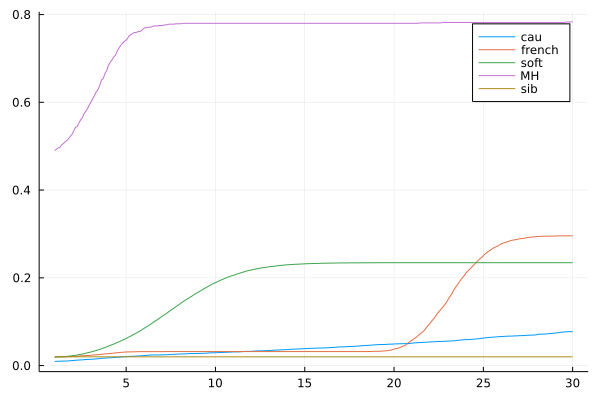

In [29]:
#Marginals
bins = 10 * Int(T)
using Plots
p_cau = zeros(N,bins)
p_french = zeros(N,bins)
p_mh = zeros(N,bins)
p_soft = zeros(N,bins)
for i = 1:N
    for t = 1:bins
       p_cau[i,t] = marginal(i, t*T/bins, statscau)
       p_french[i,t] = marginal(i, t*T/bins, statsfre)
       p_mh[i,t] = marginal(i, t*T/bins, stats_mh)
       p_soft[i,t] = marginal(i, t*T/bins, stats)
    end
end
i = 4
plot(LinRange(1,Int(T),bins),p_cau[i,:], label = "cau")
plot!(LinRange(1,Int(T),bins),p_french[i,:], label = "french")
plot!(LinRange(1,Int(T),bins),p_soft[i,:], label = "soft")
plot!(LinRange(1,Int(T),bins),p_mh[i,:], label = "MH")
plot!(LinRange(1,Int(T),Int(round(T/dt))),p_sib[i,:], label = "sib")

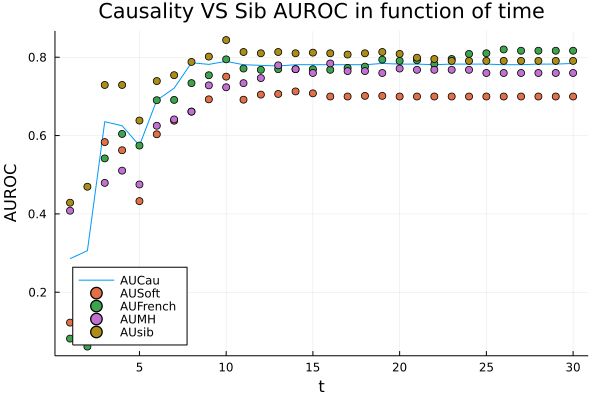

In [30]:
#AUROC curves

T = Int(T)
AU_curve=zeros(T)
AU_sib=zeros(T)
AU_french = zeros(T)
AU_soft = zeros(T)
AU_MH = zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    sib_risk = zeros(N)
    french_risk = zeros(N)
    MH_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
       french_risk[i] = marginal(i,t,statsfre)
       MH_risk[i] = marginal(i,t,stats_mh)
       sib_risk[i] = p_sib[i,Int(round(t/dt))]
       soft_risk[i] = marginal(i,t,stats) 
    end
    xt = xtrue .< t
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    AU_french[t] = AUROC(ROC(xt, french_risk))
    AU_MH[t] = AUROC(ROC(xt, MH_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end
plot(LinRange(1,T,T),AU_curve, label="AUCau", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T),AU_soft, label="AUSoft",legend=:bottomleft)
scatter!(LinRange(1,T,T),AU_french, label="AUFrench")
scatter!(LinRange(1,T,T),AU_MH, label="AUMH")
scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
#ylims!(0.5,1.01)